In [8]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

from pettingzoo.classic import tictactoe_v3
import numpy as np
import copy
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.dqn_agent import DQNAgent
from source.agents.advantage_actor_critic_agent import A2CAgent
from source.agents.ppo_agent import PPOAgent
from source.agents.random_agent import RandomAgent
from source.utils import utils
from tqdm import tqdm
import torch
import random
from typing import Dict, Optional, Tuple
from collections import defaultdict
from source.agents.agent import Agent
from pettingzoo.utils.env import AECEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


using device: cpu
using device: cpu
using device: cpu
agents: {'player_1': <source.agents.ppo_agent.PPOAgent object at 0x2a0b64310>, 'player_2': <source.agents.random_agent.RandomAgent object at 0x2a15362e0>}


100%|██████████| 1000/1000 [00:01<00:00, 582.45it/s]


epoch: 0, win: 477, lose: 403, draw: 120, reward: 0.07400, episode_len: 4.82100, value_loss: 0.15923, policy_loss: -0.05599, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 521.74it/s]


epoch: 1, win: 564, lose: 325, draw: 111, reward: 0.23900, episode_len: 4.73200, value_loss: 0.10477, policy_loss: -0.06225, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 576.02it/s]


epoch: 2, win: 654, lose: 277, draw: 69, reward: 0.37700, episode_len: 4.53800, value_loss: 0.10610, policy_loss: -0.06259, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 680.07it/s]


epoch: 3, win: 760, lose: 199, draw: 41, reward: 0.56100, episode_len: 4.44500, value_loss: 0.07243, policy_loss: -0.05831, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 926.60it/s]


epoch: 4, win: 793, lose: 162, draw: 45, reward: 0.63100, episode_len: 4.32800, value_loss: 0.07243, policy_loss: -0.05831, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 733.72it/s]


epoch: 5, win: 848, lose: 133, draw: 19, reward: 0.71500, episode_len: 4.25600, value_loss: 0.06267, policy_loss: -0.03191, num_policy_udpate: 41.50000


100%|██████████| 1000/1000 [00:01<00:00, 860.92it/s]


epoch: 6, win: 865, lose: 117, draw: 18, reward: 0.74800, episode_len: 4.16100, value_loss: 0.06267, policy_loss: -0.03191, num_policy_udpate: 41.50000


100%|██████████| 1000/1000 [00:01<00:00, 784.71it/s]


epoch: 7, win: 868, lose: 119, draw: 13, reward: 0.74900, episode_len: 4.15600, value_loss: 0.06267, policy_loss: -0.03191, num_policy_udpate: 41.50000


100%|██████████| 1000/1000 [00:01<00:00, 928.56it/s]


epoch: 8, win: 879, lose: 112, draw: 9, reward: 0.76700, episode_len: 4.14300, value_loss: 0.03795, policy_loss: -0.02403, num_policy_udpate: 8.00000


100%|██████████| 1000/1000 [00:01<00:00, 741.80it/s]


epoch: 9, win: 901, lose: 92, draw: 7, reward: 0.80900, episode_len: 4.11800, value_loss: 0.03864, policy_loss: -0.03757, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 609.99it/s]


epoch: 10, win: 880, lose: 110, draw: 10, reward: 0.77000, episode_len: 4.14100, value_loss: 0.03839, policy_loss: -0.03735, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 797.57it/s]


epoch: 11, win: 894, lose: 94, draw: 12, reward: 0.80000, episode_len: 4.13100, value_loss: 0.03839, policy_loss: -0.03735, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 783.71it/s]


epoch: 12, win: 903, lose: 88, draw: 9, reward: 0.81500, episode_len: 4.12200, value_loss: 0.03980, policy_loss: -0.02749, num_policy_udpate: 34.00000


100%|██████████| 1000/1000 [00:01<00:00, 900.13it/s]


epoch: 13, win: 888, lose: 104, draw: 8, reward: 0.78400, episode_len: 4.12800, value_loss: 0.03477, policy_loss: -0.03786, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 825.03it/s]


epoch: 14, win: 912, lose: 80, draw: 8, reward: 0.83200, episode_len: 4.14700, value_loss: 0.03640, policy_loss: -0.02536, num_policy_udpate: 32.00000


100%|██████████| 1000/1000 [00:01<00:00, 828.62it/s]


epoch: 15, win: 901, lose: 89, draw: 10, reward: 0.81200, episode_len: 4.14500, value_loss: 0.04037, policy_loss: -0.03534, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 842.12it/s]


epoch: 16, win: 914, lose: 79, draw: 7, reward: 0.83500, episode_len: 4.12900, value_loss: 0.03526, policy_loss: -0.02916, num_policy_udpate: 56.00000


100%|██████████| 1000/1000 [00:01<00:00, 773.33it/s]


epoch: 17, win: 903, lose: 87, draw: 10, reward: 0.81600, episode_len: 4.11800, value_loss: 0.03631, policy_loss: -0.03330, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 902.56it/s]


epoch: 18, win: 896, lose: 93, draw: 11, reward: 0.80300, episode_len: 4.12400, value_loss: 0.03767, policy_loss: -0.03044, num_policy_udpate: 46.50000


100%|██████████| 1000/1000 [00:01<00:00, 834.20it/s]


epoch: 19, win: 904, lose: 84, draw: 12, reward: 0.82000, episode_len: 4.12000, value_loss: 0.03374, policy_loss: -0.02379, num_policy_udpate: 45.50000


100%|██████████| 1000/1000 [00:01<00:00, 744.49it/s]


epoch: 20, win: 915, lose: 76, draw: 9, reward: 0.83900, episode_len: 4.13000, value_loss: 0.03578, policy_loss: -0.02726, num_policy_udpate: 49.66667


100%|██████████| 1000/1000 [00:01<00:00, 838.76it/s]


epoch: 21, win: 900, lose: 83, draw: 17, reward: 0.81700, episode_len: 4.15300, value_loss: 0.03764, policy_loss: -0.02656, num_policy_udpate: 45.50000


100%|██████████| 1000/1000 [00:01<00:00, 912.20it/s]


epoch: 22, win: 905, lose: 86, draw: 9, reward: 0.81900, episode_len: 4.11700, value_loss: 0.03706, policy_loss: -0.02282, num_policy_udpate: 10.00000


100%|██████████| 1000/1000 [00:01<00:00, 845.47it/s]


epoch: 23, win: 916, lose: 71, draw: 13, reward: 0.84500, episode_len: 4.15100, value_loss: 0.03629, policy_loss: -0.01800, num_policy_udpate: 41.50000


100%|██████████| 1000/1000 [00:01<00:00, 787.23it/s]


epoch: 24, win: 913, lose: 81, draw: 6, reward: 0.83200, episode_len: 4.10500, value_loss: 0.04134, policy_loss: -0.03319, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 845.53it/s]


epoch: 25, win: 916, lose: 76, draw: 8, reward: 0.84000, episode_len: 4.13800, value_loss: 0.02767, policy_loss: -0.02784, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 850.66it/s]


epoch: 26, win: 924, lose: 65, draw: 11, reward: 0.85900, episode_len: 4.13300, value_loss: 0.03498, policy_loss: -0.03031, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 847.40it/s]


epoch: 27, win: 909, lose: 82, draw: 9, reward: 0.82700, episode_len: 4.14400, value_loss: 0.03026, policy_loss: -0.01805, num_policy_udpate: 7.00000


100%|██████████| 1000/1000 [00:01<00:00, 850.39it/s]


epoch: 28, win: 921, lose: 72, draw: 7, reward: 0.84900, episode_len: 4.11700, value_loss: 0.03026, policy_loss: -0.01805, num_policy_udpate: 7.00000


100%|██████████| 1000/1000 [00:01<00:00, 907.30it/s]


epoch: 29, win: 929, lose: 63, draw: 8, reward: 0.86600, episode_len: 4.14000, value_loss: 0.02508, policy_loss: -0.02384, num_policy_udpate: 44.00000


100%|██████████| 1000/1000 [00:01<00:00, 834.20it/s]


epoch: 30, win: 919, lose: 72, draw: 9, reward: 0.84700, episode_len: 4.13400, value_loss: 0.03235, policy_loss: -0.02853, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 775.15it/s]


epoch: 31, win: 928, lose: 66, draw: 6, reward: 0.86200, episode_len: 4.13200, value_loss: 0.03274, policy_loss: -0.02825, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 861.29it/s]


epoch: 32, win: 924, lose: 69, draw: 7, reward: 0.85500, episode_len: 4.12900, value_loss: 0.02226, policy_loss: -0.02363, num_policy_udpate: 29.00000


100%|██████████| 1000/1000 [00:01<00:00, 715.05it/s]


epoch: 33, win: 923, lose: 65, draw: 12, reward: 0.85800, episode_len: 4.13200, value_loss: 0.02778, policy_loss: -0.02887, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 981.32it/s]


epoch: 34, win: 929, lose: 62, draw: 9, reward: 0.86700, episode_len: 4.13300, value_loss: 0.03226, policy_loss: -0.01855, num_policy_udpate: 10.50000


100%|██████████| 1000/1000 [00:01<00:00, 747.56it/s]


epoch: 35, win: 920, lose: 64, draw: 16, reward: 0.85600, episode_len: 4.13200, value_loss: 0.03098, policy_loss: -0.01885, num_policy_udpate: 41.50000


100%|██████████| 1000/1000 [00:01<00:00, 840.25it/s]


epoch: 36, win: 924, lose: 65, draw: 11, reward: 0.85900, episode_len: 4.13600, value_loss: 0.03477, policy_loss: -0.02815, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 842.59it/s]


epoch: 37, win: 924, lose: 65, draw: 11, reward: 0.85900, episode_len: 4.16100, value_loss: 0.03029, policy_loss: -0.02433, num_policy_udpate: 56.00000


100%|██████████| 1000/1000 [00:01<00:00, 845.97it/s]


epoch: 38, win: 920, lose: 65, draw: 15, reward: 0.85500, episode_len: 4.14000, value_loss: 0.03071, policy_loss: -0.02524, num_policy_udpate: 56.00000


100%|██████████| 1000/1000 [00:01<00:00, 814.95it/s]


epoch: 39, win: 929, lose: 58, draw: 13, reward: 0.87100, episode_len: 4.15700, value_loss: 0.02605, policy_loss: -0.02870, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 837.88it/s]


epoch: 40, win: 925, lose: 64, draw: 11, reward: 0.86100, episode_len: 4.11900, value_loss: 0.02541, policy_loss: -0.02364, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 917.97it/s]


epoch: 41, win: 934, lose: 57, draw: 9, reward: 0.87700, episode_len: 4.13800, value_loss: 0.02948, policy_loss: -0.01138, num_policy_udpate: 4.00000


100%|██████████| 1000/1000 [00:00<00:00, 1014.00it/s]


epoch: 42, win: 939, lose: 49, draw: 12, reward: 0.89000, episode_len: 4.15800, value_loss: 0.02948, policy_loss: -0.01138, num_policy_udpate: 4.00000


100%|██████████| 1000/1000 [00:01<00:00, 871.56it/s]


epoch: 43, win: 927, lose: 62, draw: 11, reward: 0.86500, episode_len: 4.16100, value_loss: 0.03070, policy_loss: -0.01377, num_policy_udpate: 22.75000


100%|██████████| 1000/1000 [00:01<00:00, 918.83it/s]


epoch: 44, win: 922, lose: 69, draw: 9, reward: 0.85300, episode_len: 4.13000, value_loss: 0.03070, policy_loss: -0.01377, num_policy_udpate: 22.75000


100%|██████████| 1000/1000 [00:01<00:00, 908.10it/s]


epoch: 45, win: 934, lose: 51, draw: 15, reward: 0.88300, episode_len: 4.14800, value_loss: 0.03043, policy_loss: -0.02138, num_policy_udpate: 45.00000


100%|██████████| 1000/1000 [00:01<00:00, 783.15it/s]


epoch: 46, win: 946, lose: 34, draw: 20, reward: 0.91200, episode_len: 4.14400, value_loss: 0.02315, policy_loss: -0.02519, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 996.24it/s]


epoch: 47, win: 937, lose: 50, draw: 13, reward: 0.88700, episode_len: 4.17000, value_loss: 0.02859, policy_loss: -0.01340, num_policy_udpate: 8.00000


100%|██████████| 1000/1000 [00:01<00:00, 887.91it/s]


epoch: 48, win: 919, lose: 63, draw: 18, reward: 0.85600, episode_len: 4.14700, value_loss: 0.02889, policy_loss: -0.01901, num_policy_udpate: 33.66667


100%|██████████| 1000/1000 [00:01<00:00, 768.13it/s]


epoch: 49, win: 920, lose: 60, draw: 20, reward: 0.86000, episode_len: 4.14900, value_loss: 0.03299, policy_loss: -0.02254, num_policy_udpate: 34.00000


100%|██████████| 1000/1000 [00:01<00:00, 848.75it/s]


epoch: 50, win: 926, lose: 56, draw: 18, reward: 0.87000, episode_len: 4.15700, value_loss: 0.02639, policy_loss: -0.02134, num_policy_udpate: 55.33333


100%|██████████| 1000/1000 [00:01<00:00, 834.96it/s]


epoch: 51, win: 934, lose: 51, draw: 15, reward: 0.88300, episode_len: 4.14000, value_loss: 0.02659, policy_loss: -0.02405, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 843.67it/s]


epoch: 52, win: 941, lose: 47, draw: 12, reward: 0.89400, episode_len: 4.14000, value_loss: 0.02671, policy_loss: -0.02329, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 763.18it/s]


epoch: 53, win: 945, lose: 41, draw: 14, reward: 0.90400, episode_len: 4.14600, value_loss: 0.02435, policy_loss: -0.02420, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 838.15it/s]


epoch: 54, win: 938, lose: 47, draw: 15, reward: 0.89100, episode_len: 4.16100, value_loss: 0.02406, policy_loss: -0.02312, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 889.55it/s]


epoch: 55, win: 936, lose: 51, draw: 13, reward: 0.88500, episode_len: 4.15100, value_loss: 0.02646, policy_loss: -0.02204, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 743.55it/s]


epoch: 56, win: 930, lose: 49, draw: 21, reward: 0.88100, episode_len: 4.14800, value_loss: 0.02446, policy_loss: -0.02287, num_policy_udpate: 62.25000


100%|██████████| 1000/1000 [00:01<00:00, 843.14it/s]


epoch: 57, win: 924, lose: 60, draw: 16, reward: 0.86400, episode_len: 4.15000, value_loss: 0.02207, policy_loss: -0.01936, num_policy_udpate: 43.00000


100%|██████████| 1000/1000 [00:01<00:00, 922.95it/s]


epoch: 58, win: 925, lose: 66, draw: 9, reward: 0.85900, episode_len: 4.14800, value_loss: 0.02811, policy_loss: -0.01327, num_policy_udpate: 5.50000


100%|██████████| 1000/1000 [00:01<00:00, 916.84it/s]


epoch: 59, win: 939, lose: 48, draw: 13, reward: 0.89100, episode_len: 4.13900, value_loss: 0.02312, policy_loss: -0.01679, num_policy_udpate: 32.33333


100%|██████████| 1000/1000 [00:01<00:00, 840.92it/s]


epoch: 60, win: 935, lose: 48, draw: 17, reward: 0.88700, episode_len: 4.14900, value_loss: 0.02416, policy_loss: -0.01987, num_policy_udpate: 44.50000


100%|██████████| 1000/1000 [00:01<00:00, 916.87it/s]


epoch: 61, win: 933, lose: 48, draw: 19, reward: 0.88500, episode_len: 4.15300, value_loss: 0.02465, policy_loss: -0.01079, num_policy_udpate: 5.00000


100%|██████████| 1000/1000 [00:01<00:00, 842.98it/s]


epoch: 62, win: 905, lose: 68, draw: 27, reward: 0.83700, episode_len: 4.14900, value_loss: 0.03244, policy_loss: -0.02679, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 799.60it/s]


epoch: 63, win: 914, lose: 59, draw: 27, reward: 0.85500, episode_len: 4.16200, value_loss: 0.03244, policy_loss: -0.02679, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 780.63it/s]


epoch: 64, win: 927, lose: 50, draw: 23, reward: 0.87700, episode_len: 4.16100, value_loss: 0.02635, policy_loss: -0.02249, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 822.96it/s]


epoch: 65, win: 937, lose: 46, draw: 17, reward: 0.89100, episode_len: 4.16400, value_loss: 0.02053, policy_loss: -0.02426, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 778.27it/s]


epoch: 66, win: 929, lose: 48, draw: 23, reward: 0.88100, episode_len: 4.16000, value_loss: 0.02375, policy_loss: -0.02804, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 847.37it/s]


epoch: 67, win: 930, lose: 55, draw: 15, reward: 0.87500, episode_len: 4.14700, value_loss: 0.02179, policy_loss: -0.02036, num_policy_udpate: 55.00000


100%|██████████| 1000/1000 [00:01<00:00, 839.36it/s]


epoch: 68, win: 945, lose: 37, draw: 18, reward: 0.90800, episode_len: 4.15200, value_loss: 0.02387, policy_loss: -0.01865, num_policy_udpate: 45.50000


100%|██████████| 1000/1000 [00:01<00:00, 836.68it/s]


epoch: 69, win: 916, lose: 59, draw: 25, reward: 0.85700, episode_len: 4.17300, value_loss: 0.02333, policy_loss: -0.02320, num_policy_udpate: 46.00000


100%|██████████| 1000/1000 [00:01<00:00, 773.31it/s]


epoch: 70, win: 930, lose: 44, draw: 26, reward: 0.88600, episode_len: 4.14400, value_loss: 0.02384, policy_loss: -0.02135, num_policy_udpate: 59.00000


100%|██████████| 1000/1000 [00:01<00:00, 785.27it/s]


epoch: 71, win: 949, lose: 35, draw: 16, reward: 0.91400, episode_len: 4.14400, value_loss: 0.02182, policy_loss: -0.02597, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 743.94it/s]


epoch: 72, win: 941, lose: 48, draw: 11, reward: 0.89300, episode_len: 4.14600, value_loss: 0.01622, policy_loss: -0.02402, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 894.68it/s]


epoch: 73, win: 936, lose: 46, draw: 18, reward: 0.89000, episode_len: 4.14400, value_loss: 0.02242, policy_loss: -0.01622, num_policy_udpate: 11.00000


100%|██████████| 1000/1000 [00:01<00:00, 831.75it/s]


epoch: 74, win: 933, lose: 56, draw: 11, reward: 0.87700, episode_len: 4.11800, value_loss: 0.03091, policy_loss: -0.02290, num_policy_udpate: 52.00000


100%|██████████| 1000/1000 [00:01<00:00, 828.30it/s]


epoch: 75, win: 936, lose: 45, draw: 19, reward: 0.89100, episode_len: 4.14300, value_loss: 0.02667, policy_loss: -0.02589, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 903.04it/s]


epoch: 76, win: 937, lose: 49, draw: 14, reward: 0.88800, episode_len: 4.16400, value_loss: 0.02395, policy_loss: -0.01905, num_policy_udpate: 33.33333


100%|██████████| 1000/1000 [00:01<00:00, 798.28it/s]


epoch: 77, win: 933, lose: 49, draw: 18, reward: 0.88400, episode_len: 4.15400, value_loss: 0.01814, policy_loss: -0.01985, num_policy_udpate: 43.00000


100%|██████████| 1000/1000 [00:02<00:00, 454.94it/s]


epoch: 78, win: 939, lose: 41, draw: 20, reward: 0.89800, episode_len: 4.13000, value_loss: 0.02322, policy_loss: -0.02423, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 826.93it/s]


epoch: 79, win: 944, lose: 42, draw: 14, reward: 0.90200, episode_len: 4.13900, value_loss: 0.02902, policy_loss: -0.02441, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 835.80it/s]


epoch: 80, win: 937, lose: 53, draw: 10, reward: 0.88400, episode_len: 4.14200, value_loss: 0.02536, policy_loss: -0.01540, num_policy_udpate: 10.00000


100%|██████████| 1000/1000 [00:01<00:00, 997.72it/s]


epoch: 81, win: 927, lose: 57, draw: 16, reward: 0.87000, episode_len: 4.12100, value_loss: 0.02515, policy_loss: -0.01374, num_policy_udpate: 11.00000


100%|██████████| 1000/1000 [00:01<00:00, 808.41it/s]


epoch: 82, win: 949, lose: 34, draw: 17, reward: 0.91500, episode_len: 4.15100, value_loss: 0.02162, policy_loss: -0.01960, num_policy_udpate: 44.50000


100%|██████████| 1000/1000 [00:01<00:00, 771.52it/s]


epoch: 83, win: 932, lose: 45, draw: 23, reward: 0.88700, episode_len: 4.16600, value_loss: 0.01897, policy_loss: -0.01446, num_policy_udpate: 41.00000


100%|██████████| 1000/1000 [00:01<00:00, 720.84it/s]


epoch: 84, win: 948, lose: 31, draw: 21, reward: 0.91700, episode_len: 4.16600, value_loss: 0.02574, policy_loss: -0.02296, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 819.63it/s]


epoch: 85, win: 948, lose: 37, draw: 15, reward: 0.91100, episode_len: 4.15600, value_loss: 0.02574, policy_loss: -0.02296, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 777.08it/s]


epoch: 86, win: 940, lose: 42, draw: 18, reward: 0.89800, episode_len: 4.15700, value_loss: 0.01773, policy_loss: -0.02164, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 784.52it/s]


epoch: 87, win: 944, lose: 44, draw: 12, reward: 0.90000, episode_len: 4.14800, value_loss: 0.02175, policy_loss: -0.02552, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 783.87it/s]


epoch: 88, win: 934, lose: 52, draw: 14, reward: 0.88200, episode_len: 4.15400, value_loss: 0.02742, policy_loss: -0.02354, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 776.84it/s]


epoch: 89, win: 932, lose: 45, draw: 23, reward: 0.88700, episode_len: 4.17200, value_loss: 0.02274, policy_loss: -0.02359, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 933.53it/s]


epoch: 90, win: 949, lose: 39, draw: 12, reward: 0.91000, episode_len: 4.16000, value_loss: 0.03190, policy_loss: -0.01076, num_policy_udpate: 4.00000


100%|██████████| 1000/1000 [00:01<00:00, 848.95it/s]


epoch: 91, win: 936, lose: 51, draw: 13, reward: 0.88500, episode_len: 4.12500, value_loss: 0.03302, policy_loss: -0.02348, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 839.71it/s]


epoch: 92, win: 940, lose: 43, draw: 17, reward: 0.89700, episode_len: 4.18300, value_loss: 0.03302, policy_loss: -0.02348, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 877.47it/s]


epoch: 93, win: 943, lose: 42, draw: 15, reward: 0.90100, episode_len: 4.14700, value_loss: 0.01273, policy_loss: -0.01370, num_policy_udpate: 8.00000


100%|██████████| 1000/1000 [00:01<00:00, 841.28it/s]


epoch: 94, win: 945, lose: 42, draw: 13, reward: 0.90300, episode_len: 4.13700, value_loss: 0.02721, policy_loss: -0.02377, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 778.84it/s]


epoch: 95, win: 948, lose: 33, draw: 19, reward: 0.91500, episode_len: 4.13800, value_loss: 0.01822, policy_loss: -0.02254, num_policy_udpate: 80.00000


100%|██████████| 1000/1000 [00:01<00:00, 837.91it/s]


epoch: 96, win: 933, lose: 43, draw: 24, reward: 0.89000, episode_len: 4.14900, value_loss: 0.02158, policy_loss: -0.01533, num_policy_udpate: 14.00000


100%|██████████| 1000/1000 [00:01<00:00, 842.22it/s]


epoch: 97, win: 935, lose: 44, draw: 21, reward: 0.89100, episode_len: 4.14600, value_loss: 0.02333, policy_loss: -0.01809, num_policy_udpate: 30.75000


100%|██████████| 1000/1000 [00:01<00:00, 844.09it/s]


epoch: 98, win: 956, lose: 32, draw: 12, reward: 0.92400, episode_len: 4.14100, value_loss: 0.02333, policy_loss: -0.01809, num_policy_udpate: 30.75000


100%|██████████| 1000/1000 [00:01<00:00, 905.68it/s]


epoch: 99, win: 943, lose: 39, draw: 18, reward: 0.90400, episode_len: 4.16500, value_loss: 0.02333, policy_loss: -0.01809, num_policy_udpate: 30.75000


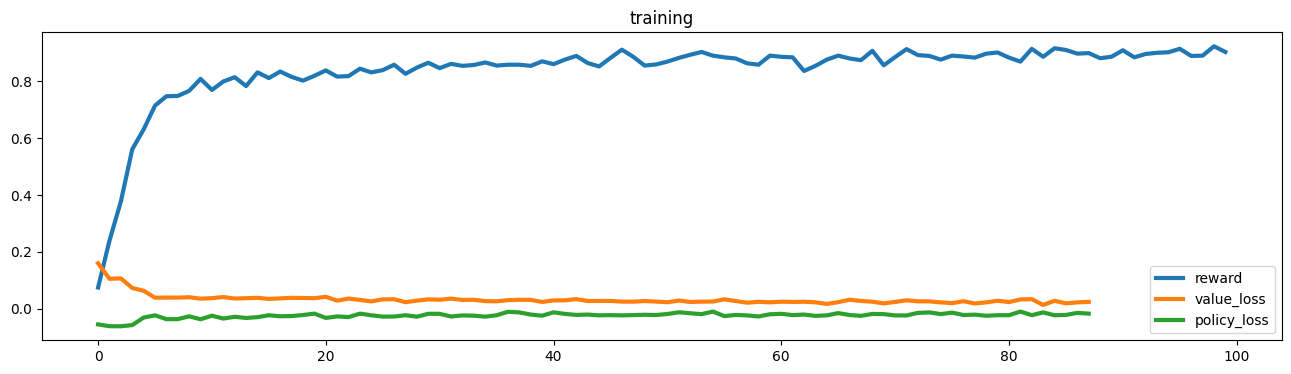

In [12]:
# Policy Eval
# Params
env = tictactoe_v3.env()

# set random seeds
random_seed = 101
rng = np.random.default_rng(random_seed)
env.np_random = rng
#random.seed(random_seed)
#torch.manual_seed(random_seed)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
#env = gym.make(
#    "LunarLander-v2",
#    render_mode='rgb_array'
#)
#env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
#env = gym.make("CartPole-v1", render_mode='rgb_array')


# Create Agent
## Best performance (dqn, random): 0 loss in 1000, eps_decay=1e7
## Best performance (dqn, dqn): 1000 draw in 1000, eps_decay=1e8
dqn_agent = DQNAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=0.9, # use epsilon_schedule
    learning_rate=1e-3,
    learning=True,
    batch_size = 64,
    tau = 0.005,
    eps_decay=1e7, #1e7 for (dqn, random), 1e8 for (dqn, dqn)
    net_params=[128],
    update_freq=1
)
## Best performance (a2c, random): ~50 loss in 1000, discount=0.5, width=256
## 
a2c_agent = A2CAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=1e-3,
    value_lr=1e-3,
    net_params=[256], #128 perform best with temp = 1
    tempreture=1
)
ppo_agent = PPOAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=1e-3, #spinup default=3e-4
    value_lr=1e-3, #spinup default=1e-3
    net_params=[128, 16],
    gae_lambda=0.97, #spinup default=0.97
    clip_ratio=0.1, #spinup default=0.1
    num_updates=80, #spinup default=80
    batch_size=1000,
)
random_agent = RandomAgent(    
    state_space=env.observation_space('player_2')['observation'],
    action_space=env.action_space('player_2'),
    discount_rate=None,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    learning=False
)
stats = utils.duel_training(
    env=env, 
    agent_dict={'player_1': ppo_agent, 'player_2': random_agent}, 
    num_epoch=100, 
    num_episode=1000, 
    self_play=True, 
    shuffle=True, 
    verbal=True,
    debug=False
)

In [ ]:
env = tictactoe_v3.env(render_mode='human')
utils.play_multiagent_episode({'player_1': ppo_agent, 'player_2': ppo_agent}, env, shuffle=False,debug=False)
#html=utils.render_mp4(video_path)
#HTML(html)


     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  -  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  O  
_____|_____|_____
     |     |     
  -  |  X  |  O  
_____|_____|_____
     |     |     
  -  |  -  |  X  
     |     |     


defaultdict(<function source.utils.utils.play_multiagent_episode.<locals>.<lambda>()>,
            {'player_1': defaultdict(float,
                         {'reward': 1.0, 'episode_len': 4.0}),
             'player_2': defaultdict(float,
                         {'reward': -1.0, 'episode_len': 3.0})})